# Evaluationf or Item x Item Feedback

Using the IMDB and MovieLens data, we build a feature matrix that we can use for user-user and item-item recommendation.

Here, we construct an Item-Item based recsys and evaluate it against our baseline.

In [1]:
%matplotlib inline

In [2]:
import json
import random
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from collections import Counter

from scipy.sparse import lil_matrix
from scipy.stats import pearsonr
from scipy.stats import spearmanr

from sklearn.neighbors import DistanceMetric
from sklearn.metrics import mean_squared_error
from sklearn.metrics import jaccard_score
from sklearn.metrics import pairwise_distances

In [3]:
known_movies = set()

user_ratings = {} # List of all our movie ratings for specific users
movie_ids = []

with open("../data/user_ratings.json", "r") as in_file:
    for line in in_file:
        
        this_rating = json.loads(line)
        
        known_movies.add(this_rating["title_id"])
        
        if this_rating["title_id"] not in movie_ids:
            movie_ids.append(this_rating["title_id"])
        
        this_users_ratings = user_ratings.get(this_rating["userId"], [])
        this_users_ratings.append((this_rating["title_id"], this_rating["rating"]))
        
        user_ratings[this_rating["userId"]] = this_users_ratings
        
        

In [4]:
movie_id_to_index = {m:i for i,m in enumerate(movie_ids)}

In [5]:
print("Known Users:", len(user_ratings))
print("Known Movies:", len(known_movies))


Known Users: 2244
Known Movies: 4465


In [6]:
actor_id_to_name_map = {}     # Map Actor IDs to actor names
actor_id_to_index_map = {}    # Map actor IDs to a unique index of known actors
index_to_actor_ids = []       # Array mapping unique index back to actor ID (invert of actor_id_to_index_map)

index_counter = 0    # Unique actor index; increment for each new actor
known_actors = set()

movie_actor_map = {} # List of all our movies and their actors

test_count = 0
with open("../data/imdb_recent_movies.json", "r") as in_file:
    for line in in_file:
        
        this_movie = json.loads(line)
        
        # Restrict to known movies
        if this_movie["title_id"] not in known_movies:
            continue
            
        # Keep track of all the actors in this movie
        for actor_id,actor_name in zip(this_movie['actor_ids'],this_movie['actor_names']):
            
            # Keep names and IDs
            actor_id_to_name_map[actor_id] = actor_name
            
            # If we've seen this actor before, skip...
            if actor_id in known_actors:
                continue
                
            # ... Otherwise, add to known actor set and create new index for them
            known_actors.add(actor_id)
            actor_id_to_index_map[actor_id] = index_counter
            index_to_actor_ids.append(actor_id)
            index_counter += 1
            
        # Finished with this film
        movie_actor_map[this_movie["title_id"]] = ({
            "movie": this_movie["title_name"],
            "actors": set(this_movie['actor_ids']),
            "genres": this_movie["title_genre"]
        })

In [7]:
print("Known Actors:", len(known_actors))
print("Known Movies:", len(movie_actor_map))

Known Actors: 5224
Known Movies: 4465


## Generate DataFrame using Sparse Matrics

Convert our Movie Ratings data into a DataFrame that we can use for analysis.

In [8]:
# With sparse matrix, initialize to size of Users x Movies of 0s
matrix_sparse = lil_matrix((len(user_ratings), len(known_movies)), dtype=float)

# Update the matrix, user by user, setting non-zero values for the appropriate actors
for row,this_user in enumerate(user_ratings): 
    this_user_ratings = user_ratings[this_user]
    
    for movie_id,rating in this_user_ratings:
        this_movie_index = movie_id_to_index[movie_id]
        matrix_sparse[row,this_movie_index] = rating

In [9]:
df = pd.DataFrame.sparse.from_spmatrix(
    matrix_sparse, 
    index=[u for u in user_ratings],
    columns=movie_ids
).T
df

,10,37,51,126,152,263,284,448,626,706,...,162002,162073,162207,162257,162363,162420,162434,162464,162499,162537
tt0274309,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0298203,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0315733,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0337563,1.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0463854,4.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt4241904,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
tt1666800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
tt6806448,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0844671,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0


In [10]:
print("Movies x Users dimensionality:", df.shape)

Movies x Users dimensionality: (4465, 2244)


## Hold Out Data for Evaluation

We want to extract a set of test users on which we can evaluate our recsys. For each test user, we need to split their behavior into a seen set that we can use for recommendation and an unseen set we can use for evaluation.

In [11]:
user_by_movie_df = df.T

In [12]:
held_out_users = np.random.choice(user_by_movie_df.index, size=100)
held_out_users

array(['61120', '117688', '51722', '8218', '83209', '148032', '33666',
       '6875', '33368', '149360', '78933', '152261', '43607', '104566',
       '107434', '150468', '22927', '132242', '134939', '37746', '123631',
       '284', '70671', '72716', '26384', '155912', '61557', '66045',
       '62314', '96101', '142931', '39631', '98347', '158046', '11952',
       '139538', '116349', '32180', '50848', '117581', '40521', '66657',
       '149062', '22693', '159709', '16027', '135837', '53622', '107040',
       '14813', '131044', '46927', '18188', '35990', '43842', '110276',
       '159262', '151848', '68575', '21534', '144865', '58327', '68961',
       '6004', '130631', '31211', '157961', '38626', '15103', '112622',
       '117595', '97680', '95077', '29311', '28732', '73139', '135629',
       '98022', '26309', '140589', '33565', '64943', '65121', '27377',
       '104566', '7391', '154478', '65391', '149585', '1825', '112582',
       '69698', '99405', '5510', '143030', '112724', '158919',

In [13]:
held_out_movies = np.random.choice(user_by_movie_df.columns, size=100)
held_out_movies

In [24]:
held_out_movies

array(['tt1710396', 'tt0260866', 'tt3717252', 'tt0303785', 'tt3402236',
       'tt0884224', 'tt0189541', 'tt0361089', 'tt3335606', 'tt0449487',
       'tt5825380', 'tt0330136', 'tt1331307', 'tt6306064', 'tt0910936',
       'tt1531901', 'tt8954732', 'tt1954315', 'tt0310154', 'tt2371158',
       'tt0845046', 'tt2184233', 'tt1496025', 'tt1331064', 'tt0396592',
       'tt2309260', 'tt0266697', 'tt6452332', 'tt2253939', 'tt0196069',
       'tt0242423', 'tt1405809', 'tt0338096', 'tt7427356', 'tt0222812',
       'tt4943322', 'tt2395427', 'tt2109184', 'tt0289848', 'tt0489037',
       'tt0234354', 'tt1978480', 'tt1407061', 'tt1212450', 'tt0884224',
       'tt1478964', 'tt3177316', 'tt2910342', 'tt0244970', 'tt0278488',
       'tt1564585', 'tt0418110', 'tt2375761', 'tt2667380', 'tt0206926',
       'tt2967224', 'tt2709692', 'tt3566788', 'tt0478311', 'tt0241025',
       'tt2124787', 'tt0388182', 'tt1653665', 'tt2309961', 'tt0338427',
       'tt0273435', 'tt1659343', 'tt5328340', 'tt4669186', 'tt37

In [14]:
# This new DataFrame has zeros where ratings used to be
training_df = user_by_movie_df.sparse.to_dense()
for test_user in held_out_users:
    for test_movie in held_out_movies:
        training_df.loc[test_user][test_movie] = 0.0

### Baseline Recs using Most Popular Movies

As a baseline, let's rank movies by their global popularity

In [15]:
# Let's make a dataframe of just the training users, so we can evaluate
held_in_users_df = training_df.loc[[u for u in training_df.index if u not in held_out_users]]

In [16]:
agg_movie_ratings_ = held_in_users_df.sum(axis=0)
agg_movie_ratings = 5 * (agg_movie_ratings_ / agg_movie_ratings_.max())

for movie_id,sum_rating in agg_movie_ratings.sort_values(ascending=False).head(20).items():
    print(movie_id, movie_actor_map[movie_id]["movie"], sum_rating)

tt0209144 Memento 5.0
tt0172495 Gladiator 4.901262544512787
tt1375666 Inception 4.876173518938168
tt0126029 Shrek 4.4342829394626095
tt0338013 Eternal Sunshine of the Spotless Mind 4.153447717707996
tt0266543 Finding Nemo 3.9511168662997735
tt0198781 Monsters, Inc. 3.8847523470378764
tt0266697 Kill Bill: Vol. 1 3.7625445127873096
tt0910970 WALL·E 3.39592101003561
tt0372784 Batman Begins 3.355454839753966
tt0240772 Ocean's Eleven 3.2680479119456134
tt0378194 Kill Bill: Vol. 2 3.2599546778892847
tt0246578 Donnie Darko 3.137746843638718
tt0181689 Minority Report 3.0940433797345417
tt0120903 X-Men 3.088378115895112
tt1049413 Up 3.0252508902557462
tt0264464 Catch Me If You Can 3.0163483327937843
tt0162222 Cast Away 2.8455810942052446
tt0145487 Spider-Man 2.818873421819359
tt0208092 Snatch 2.7557461961799934


## Function for Generating Recommendations based on Item Similarity

In [131]:
def recs_for_user(query_user, local_df, top_k=5, threshold=0.5, centering=False):

    centered_df = local_df
    
    if centering:
        # center user ratings
        centers = local_df.apply(lambda row: np.mean([x for x in row if x > 0]), axis=1)
        centers_map = {uid:c for uid,c in centers.items()}
        centered_df = pd.DataFrame([[v-centers_map[uid] if v > 0 else 0 for v in row] for uid,row in local_df.iterrows()])
        centered_df.index = local_df.index
        centered_df.columns = local_df.columns
    
    # Transpose the centered matrix
    movie_rating_centered_df = centered_df.T

    # Find movies this query user has ranked
    query_ranked_movies = local_df.columns[local_df.loc[query_user] > 0]
    
    # We only care about rating movies that the user has NOT seen
    query_unranked_movies = local_df.columns[local_df.loc[query_user] == 0]
    
    # Map of this user's ratings
    query_user_item_ratings = {movie_id:rating 
                               for movie_id,rating in local_df.loc[query_user][query_ranked_movies].items()
                              }
    
    # Find pairwise distances between items with rating and all others
    item_distances = pairwise_distances(
        movie_rating_centered_df.loc[query_ranked_movies], 
        movie_rating_centered_df.loc[query_unranked_movies], 
        metric="cosine"
    )

    # Convert to similarity rather than distance
    item_similarities = 1 - item_distances

    # List for storing our predicted ratings
    inferred_movie_ratings = []

    # For every movie we haven't seen, which make up the columns of this sim matrix...
    for col in range(item_similarities.shape[1]):

        # Get the name of this unseen movie
        this_unseen_movie = query_unranked_movies[col]

        # Join movies seen and their similarities with the unseen movies, skipping items with similarity below threshold
        this_rel_movies = [(m_id,sim) for m_id,sim in zip(query_ranked_movies, item_similarities[:,col]) if sim > threshold]

        # Take only the top k most similar movies
        rel_movie_ratings = sorted(this_rel_movies, key=lambda tup: tup[1], reverse=True)[:top_k]

        # If we have no similar movies, skip
        if len(rel_movie_ratings) == 0:
            inferred_movie_ratings.append((this_unseen_movie, 0.0))
            continue

        # Re-weight the user's rating of this movie by its similarity to the unseen movie
        this_summed_score = sum([query_user_item_ratings[mid] * sim for mid,sim in rel_movie_ratings])

        # Normalize by the similarity across all rel movies
        this_summed_sim = sum([sim for mid,sim in rel_movie_ratings])

        # Calculate inferred score
        inferred_rating = this_summed_score / this_summed_sim    
        inferred_movie_ratings.append((this_unseen_movie, inferred_rating))


    inferred_ratings = pd.Series([r for m,r in inferred_movie_ratings])
    inferred_ratings.index = [m for m,r in inferred_movie_ratings]
    
    return inferred_ratings


In [133]:
recs_for_user("90141", training_df, top_k=5, centering=False).sort_values(ascending=False).head(20)

tt1049413    5.000000
tt0365737    5.000000
tt0910970    5.000000
tt0371746    4.500000
tt0800039    4.500000
tt0180093    4.500000
tt0162222    4.500000
tt0830515    4.500000
tt0338013    4.369934
tt0372784    4.300401
tt0266543    4.280399
tt0268380    4.163309
tt0264464    4.119849
tt0378194    4.117762
tt0266697    4.114650
tt0926084    4.000000
tt0417741    4.000000
tt1156398    4.000000
tt0413300    4.000000
tt0467406    4.000000
dtype: float64

In [119]:
# Find movies this query user has ranked
query_user = "90141"
query_ranked_movies = training_df.columns[training_df.loc[query_user] > 0]

# Print this user's rated movies, ranked by rating
for movie_id, rating in training_df.loc[query_user].sort_values(ascending=False).items():
    # Only print movies that have a rating
    if rating == 0:
        continue
        
    print(movie_id, movie_actor_map[movie_id]["movie"], rating)

tt0382932 Ratatouille 5.0
tt0375679 Crash 5.0
tt0443453 Borat: Cultural Learnings of America for Make Benefit Glorious Nation of Kazakhstan 5.0
tt0335266 Lost in Translation 5.0
tt0379725 Capote 5.0
tt0433383 Good Night, and Good Luck. 5.0
tt0388795 Brokeback Mountain 5.0
tt0126029 Shrek 4.5
tt0478311 Knocked Up 4.5
tt0120755 Mission: Impossible II 4.5
tt0290334 X2: X-Men United 4.5
tt0381061 Casino Royale 4.5
tt0190590 O Brother, Where Art Thou? 4.5
tt0259446 My Big Fat Greek Wedding 4.5
tt0401792 Sin City 4.5
tt0172495 Gladiator 4.5
tt0259711 Vanilla Sky 4.5
tt0246578 Donnie Darko 4.5
tt0295297 Harry Potter and the Chamber of Secrets 4.0
tt0276751 About a Boy 4.0
tt0145487 Spider-Man 4.0
tt0395169 Hotel Rwanda 4.0
tt0258000 Panic Room 4.0
tt0365748 Shaun of the Dead 4.0
tt0369339 Collateral 4.0
tt0343818 I, Robot 4.0
tt0316654 Spider-Man 2 4.0
tt0198781 Monsters, Inc. 4.0
tt0120903 X-Men 4.0
tt0240772 Ocean's Eleven 4.0
tt0298148 Shrek 2 4.0
tt0425112 Hot Fuzz 4.0
tt0450259 Blood Dia

### Evaluate This Baseline on the Held-Out Users

In [19]:
# For Precision@k, set k to a reasonably low value
#. It's low because we don't want to provide many recommendations
top_k = 3

In [20]:
base_metrics = []

for u in held_out_users:

    this_held_out_movies = user_by_movie_df.loc[u][held_out_movies]
    if sum(this_held_out_movies) == 0:
        print("Skipping user with no ratings in held-out set:", u)
        continue

    # Calculate mean squared error
    mse = mean_squared_error(this_held_out_movies, agg_movie_ratings[held_out_movies])
    
    # Pearson correlation for rankings
    corr_p = pearsonr(this_held_out_movies, agg_movie_ratings[held_out_movies])[0]
    
    # Spearman correlation for *rankings* rather than overall ratings
    corr_s = spearmanr(this_held_out_movies, agg_movie_ratings[held_out_movies]).correlation
    
    # Top k rankings, i.e., what's the similarity between the top-k for this user and all the dataset?
    this_top_k = set(this_held_out_movies.sort_values(ascending=False).head(top_k).keys())
    global_top_k = set(agg_movie_ratings[held_out_movies].sort_values(ascending=False).head(top_k).keys())

    # What's the Precision between this user's top-k and global top-k?
    precision_at_k = len(this_top_k.intersection(global_top_k)) / len(this_top_k)
    
    base_metrics.append({
        "mse": mse,
        "pearson": corr_p,
        "spearman": corr_s,
        "pr@k": precision_at_k,
    })
    

Skipping user with no ratings in held-out set: 117688
Skipping user with no ratings in held-out set: 51722
Skipping user with no ratings in held-out set: 83209
Skipping user with no ratings in held-out set: 148032
Skipping user with no ratings in held-out set: 33666
Skipping user with no ratings in held-out set: 33368
Skipping user with no ratings in held-out set: 149360
Skipping user with no ratings in held-out set: 152261
Skipping user with no ratings in held-out set: 107434
Skipping user with no ratings in held-out set: 22927
Skipping user with no ratings in held-out set: 132242
Skipping user with no ratings in held-out set: 37746
Skipping user with no ratings in held-out set: 123631
Skipping user with no ratings in held-out set: 26384
Skipping user with no ratings in held-out set: 155912
Skipping user with no ratings in held-out set: 62314
Skipping user with no ratings in held-out set: 96101
Skipping user with no ratings in held-out set: 142931
Skipping user with no ratings in held

In [21]:
base_metrics_df = pd.DataFrame(base_metrics)
base_metrics_df.mean()

mse         0.260393
pearson     0.631305
spearman    0.240923
pr@k        0.368421
dtype: float64

In [141]:
new_metrics = []

for u in held_out_users:

    this_held_out_movies = user_by_movie_df.loc[u][held_out_movies]
    if sum(this_held_out_movies) == 0:
        print("Skipping user with no ratings in held-out set:", u)
        continue
        
    i2i_movie_ratings = recs_for_user(u, training_df, top_k=3, centering=False)

    # Calculate mean squared error
    mse = mean_squared_error(this_held_out_movies, i2i_movie_ratings[held_out_movies])
    
    # Pearson correlation for rankings
    corr_p = pearsonr(this_held_out_movies, i2i_movie_ratings[held_out_movies])[0]
    
    # Spearman correlation for *rankings* rather than overall ratings
    corr_s = spearmanr(this_held_out_movies, i2i_movie_ratings[held_out_movies]).correlation
    
    # Top k rankings, i.e., what's the similarity between the top-k for this user and all the dataset?
    this_top_k = set(this_held_out_movies.sort_values(ascending=False).head(top_k).keys())
    global_top_k = set(i2i_movie_ratings[held_out_movies].sort_values(ascending=False).head(top_k).keys())

    # What's the Precision between this user's top-k and global top-k?
    precision_at_k = len(this_top_k.intersection(global_top_k)) / len(this_top_k)
    
    new_metrics.append({
        "mse": mse,
        "pearson": corr_p,
        "spearman": corr_s,
        "pr@k": precision_at_k,
    })
    


Skipping user with no ratings in held-out set: 117688
Skipping user with no ratings in held-out set: 51722
Skipping user with no ratings in held-out set: 83209
Skipping user with no ratings in held-out set: 148032
Skipping user with no ratings in held-out set: 33666
Skipping user with no ratings in held-out set: 33368
Skipping user with no ratings in held-out set: 149360
Skipping user with no ratings in held-out set: 152261


/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Skipping user with no ratings in held-out set: 107434
Skipping user with no ratings in held-out set: 22927
Skipping user with no ratings in held-out set: 132242
Skipping user with no ratings in held-out set: 37746


/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Skipping user with no ratings in held-out set: 123631


/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Skipping user with no ratings in held-out set: 26384
Skipping user with no ratings in held-out set: 155912
Skipping user with no ratings in held-out set: 62314
Skipping user with no ratings in held-out set: 96101
Skipping user with no ratings in held-out set: 142931
Skipping user with no ratings in held-out set: 39631
Skipping user with no ratings in held-out set: 98347
Skipping user with no ratings in held-out set: 32180
Skipping user with no ratings in held-out set: 50848
Skipping user with no ratings in held-out set: 117581
Skipping user with no ratings in held-out set: 149062
Skipping user with no ratings in held-out set: 22693
Skipping user with no ratings in held-out set: 16027
Skipping user with no ratings in held-out set: 107040
Skipping user with no ratings in held-out set: 14813
Skipping user with no ratings in held-out set: 131044
Skipping user with no ratings in held-out set: 35990
Skipping user with no ratings in held-out set: 110276
Skipping user with no ratings in held-o

/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/cbuntain/Development/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Skipping user with no ratings in held-out set: 154478
Skipping user with no ratings in held-out set: 65391
Skipping user with no ratings in held-out set: 149585
Skipping user with no ratings in held-out set: 1825
Skipping user with no ratings in held-out set: 112582
Skipping user with no ratings in held-out set: 69698
Skipping user with no ratings in held-out set: 99405
Skipping user with no ratings in held-out set: 5510
Skipping user with no ratings in held-out set: 112724
Skipping user with no ratings in held-out set: 82123
Skipping user with no ratings in held-out set: 113222


In [142]:
new_metrics_df = pd.DataFrame(new_metrics)
new_metrics_df.mean()

mse         0.454920
pearson     0.600100
spearman    0.584837
pr@k        0.561404
dtype: float64

## Visually Compare Metrics

Plot the performance metrics between the baseline and provided recommendations, with ~95% confidence interval error bars, so we can see whether we get significant increases.

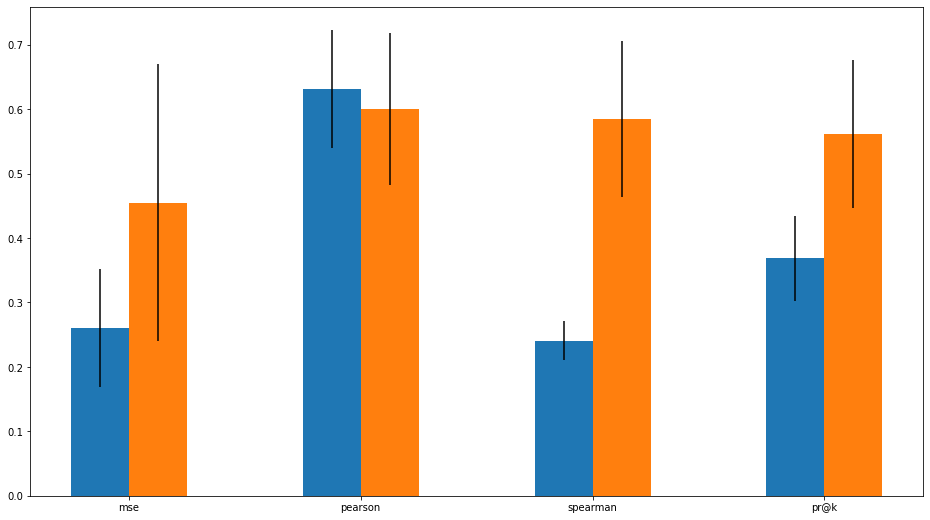

In [143]:
figure = plt.figure(figsize=(16,9))
ax = figure.add_subplot(1,1,1)

base_metric_err = 2*base_metrics_df.std() / np.sqrt(base_metrics_df.shape[0])
new_metric_err = 2 * new_metrics_df.std() / np.sqrt(new_metrics_df.shape[0])

width = 0.25
ax.bar(x=[x-width/2 for x in range(4)], height=base_metrics_df.mean(), yerr=base_metric_err, width=width)
ax.bar(x=[x+width/2 for x in range(4)], height=new_metrics_df.mean(), yerr=new_metric_err,  width=width)

ax.set_xticks(range(4))
ax.set_xticklabels(base_metrics_df.columns)

plt.show()